In [1]:
import cnot_network

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sbs
import numpy as np
sbs.set_context("paper")
sbs.set_theme()
sbs.set_style("dark")

from surface_code_routing.tikz_utils import tikz, tex

sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

def plt_data(condition, x_axis, y_axis, target=None):
    data = filter(lambda x: x[0] == target, zip(condition, x_axis, y_axis))
    x = []
    y = []
    for _, x_val, y_val in data:
        x.append(x_val)
        y.append(y_val)
    return {'x':x, 'y':y}

def plt_data_multi(data, x_axis, y_axis, **targets):
    idx_map = {j:i for i, j in enumerate(data)}
    rev_map = {j:i for i, j in idx_map.items()}

    iters = zip(*[iter(data[rev_map[i]]) for i, _ in enumerate(data)])

    x = []
    y = []
    for it in iters:
        checks = True
        for targ in targets:
            if it[idx_map[targ]] != targets[targ]:
                checks = False
        if not checks:
            continue
            
        x.append(it[idx_map[x_axis]])
        y.append(it[idx_map[y_axis]])
    return {'x':x, 'y':y}

In [2]:
from surface_code_routing.dag import DAG
from surface_code_routing.symbol import Symbol 
from surface_code_routing.instructions import INIT, CNOT, MEAS, X, Hadamard, SWAP
from surface_code_routing.lib_instructions import T_Factory, CSWAP
from surface_code_routing.compiled_qcb import compile_qcb

In [3]:
import cnot_network
from functools import partial
from surface_code_routing.lib_instructions import T_Factory, Toffoli, T_gate

toff_height = 14
toff_width = toff_height

t_factory_l1 = cnot_network.T_Factory()
toffoli_gate = cnot_network.Toffoli

t_factory_l2 = T_Factory(t_factory_l1, height=8, width=10, t_gate=T_gate(t_factory_l1))
t_gate_l2 = T_gate(factory=t_factory_l2)

t_factory_l3 = T_Factory(t_factory_l2, height=11, width=12, t_gate=T_gate(t_factory_l2))
t_gate_l3 = T_gate(factory=t_factory_l3)

extern_toffoli_l1 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l1)
extern_toffoli_l2 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l2)
extern_toffoli_l3 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l3)

# Raw T injection sites
ccz_factory_l1 = cnot_network.CCZ_factory(6, 4, t_factory=None)
ccz_factory_l2 = cnot_network.CCZ_factory(9, 7, t_factory=t_factory_l1)
ccz_factory_l3 = cnot_network.CCZ_factory(11, 11, t_factory=t_factory_l2)

t_factories = (t_factory_l1, t_factory_l2, t_factory_l3)
extern_toffolis = (extern_toffoli_l1, extern_toffoli_l2, extern_toffoli_l3)
ccz_factories = (ccz_factory_l1, ccz_factory_l2, ccz_factory_l3)

In [4]:
toffoli = partial(Toffoli, T=T_gate(factory=t_factory_l1))

toffoli = cnot_network.toff_extern(extern_toffoli_l1)

toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

In [5]:
def BB(*externs, height=32, width=32, CSWAP=CSWAP, **compiler_arguments):
    '''
    Base Bucket Brigade Object
    '''
    registers = ('ctrl', 'route', 'targ_0', 'targ_1')
    dag = DAG(Symbol('BB', registers, registers))

    dag.add_gate(X(f'ctrl'))
    dag.add_gate(CSWAP(f'ctrl', f'route', f'targ_0'))
    dag.add_gate(X(f'ctrl'))
    dag.add_gate(CSWAP(f'ctrl', f'route', f'targ_1'))

    return compile_qcb(dag, height, width, *externs, **compiler_arguments)

Build some fast bb externs

In [6]:
factory = ccz_factory_l1

ccz_toffoli_gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=factory)
cswap = partial(CSWAP, Toffoli=ccz_toffoli_gate)

height = 10
width = 14

while True:
    try:
        bb = BB(factory, CSWAP=cswap, height=height, width=width)
        while len(bb.dag.physical_externs) < 3: # Rebake until we get something good
            print('\rBB1:', len(bb.dag.physical_externs), bb.space_time_volume(), bb.n_cycles(), ' ' * 10, flush=True, end='')
            bb = BB(factory, CSWAP=cswap, height=height, width=width)
        break
    except:
        continue
print('\r# BB1:', len(bb.dag.physical_externs), bb.space_time_volume(), bb.n_cycles(), ' ' * 10, flush=True, end='')

bb_1 = bb
print()

height = 22
width = 14
factory = ccz_factory_l2

bb = BB(factory, CSWAP=cswap, height=height, width=width)
while len(bb.dag.physical_externs) < 3: # Rebake until we get something good
    print('\rBB2:', len(bb.dag.physical_externs), bb.space_time_volume(), bb.n_cycles(), ' ' * 10, flush=True, end='')
    bb = BB(factory, CSWAP=cswap, height=height, width=width)
print('\r# BB2:', len(bb.dag.physical_externs), bb.space_time_volume(), bb.n_cycles(), ' ' * 10, flush=True, end='')

bb_2 = bb
print()

height = 38
width = 14
factory = ccz_factory_l3

bb = BB(factory, CSWAP=cswap, height=height, width=width)
while len(bb.dag.physical_externs) < 3: # Rebake until we get something good
    print('\rBB3:', len(bb.dag.physical_externs), bb.space_time_volume(), bb.n_cycles(), ' ' * 10, flush=True, end='')
    bb = BB(factory, CSWAP=cswap, height=height, width=width, allocator_kwargs={'over_allocate': True})
print('\r# BB3:', len(bb.dag.physical_externs), bb.space_time_volume(), bb.n_cycles(), ' ' * 10, flush=True, end='')

bb_3 = bb

bbs_fast = (bb_1, bb_2, bb_3)

# BB1: 3 1052 41           
# BB2: 3 28853 328           
# BB3: 3 715033 4680           

Build some small bb externs

In [7]:
factory = ccz_factory_l1
ccz_toffoli_gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=factory)
cswap = partial(CSWAP, Toffoli=ccz_toffoli_gate)

bb = BB(factory, CSWAP=cswap, height=9, width=4)
bb_1 = bb
factory = ccz_factory_l2

bb = BB(factory, CSWAP=cswap, height=12, width=7)
bb_2 = bb

factory = ccz_factory_l3

bb = BB(factory, CSWAP=cswap, height=14, width=11)
bb_3 = bb

bbs_small = (bb_1, bb_2, bb_3)

In [8]:
def bucket_brigade_gadget(address_size, line_width, width, height, *externs, compile=True, readout=CNOT, BB=None, **compiler_args):
    def bb(*args):
        dag = BB.instruction(args=args, targs=args)
        return dag
         
    dag = DAG(Symbol('qram_bucket_brigade', ['query_{i}'.format(i=i) for i in range(address_size)] , ['readout_{i}'.format(i=i) for i in range(line_width)]))

    int_to_bin = lambda x: bin(x)[2:]

    for target_anc in range(line_width):
        anc = int_to_bin(target_anc)
        dag.add_gate(INIT(f'route_root_{anc}'))
    dag.add_gate(INIT(f'ctrl_root'))

    for layer in range(1 << (address_size - 1)):
        layer = int_to_bin(layer)
        dag.add_gate(INIT(f'ctrl_{layer}'))

        for anc in range(line_width):
            dag.add_gate(INIT(f'route_{layer}_{anc}'))

    for layer in range(1 << address_size):
        layer = int_to_bin(layer)
        for addr in range(line_width):
            dag.add_gate(INIT(f'mem_{layer}_{addr}'))


    # Build routing network
    for i in range(address_size):

        dag.add_gate(SWAP(f'query_{i}', f'ctrl_root'))
        if i > 0:
            dag.add_gate(bb(f'ctrl_root', 'route_root', 'route_0_0', 'route_1_0'))
        else:
            dag.add_gate(SWAP(f'query_{i}', f'ctrl_root'))
            dag.add_gate(bb(f'ctrl_root', 'route_root', 'route_0_0', 'route_1_0'))
            continue

        # Route previous layers
        for layer in range(i - 1):
            if layer > 0:
                for last_layer in range(1 << (layer - 1)):
                    last_layer = int_to_bin(last_layer)
                    dag.add_gate(bb(f'ctrl_{last_layer}', f'route_{last_layer}_0', f'route_{last_layer}0_0', f'route_{last_layer}1_0)'))


        # Control current layer
        for last_layer in range(1 << (i - 1)):
            addr = int_to_bin(last_layer)
            dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_0', f'ctrl_{addr}0', f'ctrl_{addr}0)'))

    # Readout
    for i in range(1 << (address_size - 1)):
        addr = int_to_bin(i).zfill(address_size - 1)
        for idx in range(line_width):
            dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_{idx}', f'mem_{addr}0_{idx}', f'mem_{addr}1_{idx})'))

    # Back prop routes
    for i in range(address_size - 1, 1, -1): 
        for layer in range(1, i):
            for last_layer in range(1 << (layer - 1)):
                addr = int_to_bin(last_layer)
                for idx in range(line_width):
                    dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_{idx}', f'route_{addr}0', f'route_{addr}1_{idx})'))

    for idx in range(line_width):
        dag.add_gate(bb(f'ctrl_root', f'route_root_{idx}', f'route_0_{idx}0', f'route_0_{idx}1'))

    # Performing Readout
    for index in range(line_width):
        dag.add_gate(readout(f'mem_0_{index}', f'readout_{index}'))

    for idx in range(line_width):
        dag.add_gate(bb(f'ctrl_root', f'route_root_{idx}', f'route_0_{idx}0', f'route_0_{idx}1'))


    # Forward prop routes
    for i in range(address_size): 
        for layer in range(1, i):
            for last_layer in range(1 << (layer - 1)):
                addr = int_to_bin(last_layer)
                for idx in range(line_width):
                    dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_{idx}', f'route_{addr}0', f'route_{addr}1_{idx})'))


    # Memory Readin
    for i in range(1 << (address_size - 1)):
        addr = int_to_bin(i).zfill(address_size - 1)
         
        dag.add_gate(X(f'ctrl_{addr}'))
        for idx in range(line_width):
            dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_{idx}', f'mem_{addr}0_{idx}', f'mem_{addr}1_{idx})'))
            #print('\t','MEM', f'ctrl_{addr}', f'route_{addr}_{idx}', f'mem_{addr}1_{idx}')

    # Unbuild routing network
    for i in range(address_size - 1, -1, -1):

         # Control current layer
        if i > 0:
            for last_layer in range(1 << (i - 1)):
                addr = int_to_bin(last_layer)
                dag.add_gate(bb(f'ctrl_{addr}', f'route_{addr}_0', f'ctrl_{addr}0', f'ctrl_{addr}0)'))
                
        # Route previous layers
        for layer in range(i - 1):
            if layer > 0:
                for last_layer in range(1 << (layer - 1)):
                    last_layer = int_to_bin(last_layer)
                    dag.add_gate(bb(f'ctrl_{last_layer}', f'route_{last_layer}_0', f'route_{last_layer}0_0', f'route_{last_layer}0_1)'))

        if i > 0:
            dag.add_gate(bb(f'ctrl_root', 'route_root', 'route_0_0', 'route_1_0'))
        else:
            dag.add_gate(bb(f'ctrl_root', 'route_root', 'route_0_0', 'route_1_0'))
            dag.add_gate(SWAP(f'query_{i}', f'ctrl_root'))

        dag.add_gate(SWAP(f'query_{i}', f'ctrl_root'))
    
    if compile:
        return compile_qcb(dag, height, width, BB, *externs, **compiler_args) 
    else:
        return dag

Sample construction

In [9]:
qcb = bucket_brigade_gadget(6, 1, 24, 24, BB=bb)

In [10]:
qcb.space_time_volume()

946701572

Generating results for figures

In [11]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'address':[], 'width':[]}
sizes = [16, 32, 48, 64]

toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

min_reg = 1
max_reg = 8

for addr in range(min_reg, max_reg + 1):
    for size in sizes:
        for width in (1, 2):
            for distillery, extern in zip((1, 2, 3), bbs_small):
                print(f"\r Compiling: {addr} {size} {distillery}" + " " * 5, flush=True, end='')
                try:
                    qcb = bucket_brigade_gadget(addr, width, size, size, BB=extern)
                    results['height'].append(size)
                    results['width'].append(width)
                    results['distillery'].append(distillery)
                    results['volume'].append(qcb.space_time_volume())
                    results['runtime'].append(qcb.n_cycles())
                    results['address'].append(addr)
                    del qcb
                except: # This will likely be an allocation size issue
                    pass
        
results_small = results

 Compiling: 8 64 3     

In [9]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'address':[], 'width':[]}
sizes = [16, 32, 48, 64]

toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

min_reg = 1
max_reg = 8

for addr in range(min_reg, max_reg + 1):
    for size in sizes:
        for width in (1, 2):
            for distillery, extern in zip((1, 2, 3), bbs_fast):
                print(f"\r Compiling: {addr} {size} {distillery}" + " " * 5, flush=True, end='')
                try:
                    qcb = bucket_brigade_gadget(addr, width, size, size, BB=extern)
                    results['height'].append(size)
                    results['width'].append(width)
                    results['distillery'].append(distillery)
                    results['volume'].append(qcb.space_time_volume())
                    results['runtime'].append(qcb.n_cycles())
                    results['address'].append(addr)
                    del qcb
                except: # This will likely be an allocation size issue
                    pass
        
results_bb_fast = results

 Compiling: 8 64 3     

Pre-generated results - if needed

In [13]:
results_bb_small = {'height': [16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 48, 48, 48, 64, 64, 64, 64, 64, 64], 'distillery': [1, 2, 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3], 'volume': [14500, 279887, 34810, 622483, 17189, 287432, 5665752, 30810, 532885, 9769835, 20142, 300707, 5723737, 36391, 569305, 10387466, 22829, 307603, 5695694, 43122, 615507, 10976058, 43929, 696524, 70109, 1258861, 35121, 628758, 12394528, 71308, 1043732, 20581490, 49607, 619709, 11809455, 73876, 1128223, 21286200, 51244, 648675, 11588042, 84932, 1097638, 19634986, 100692, 1919225, 298282, 3913652, 92568, 1484843, 29663801, 170975, 2410688, 44249290, 92593, 1513192, 26586544, 176651, 2418849, 44024208, 109932, 1517047, 25327833, 185329, 2486635, 44925030, 436933, 5792485, 901181, 295855, 3787600, 78784781, 475799, 7197564, 160810374, 275387, 4234907, 68402776, 508546, 7548476, 124726375, 301074, 4043659, 71428426, 596998, 7897820, 129381840, 756957, 11178977, 193676210, 1512506, 20117175, 368312883, 843355, 10477804, 175873836, 1615939, 19944446, 317154693, 861217, 11584265, 182280221, 1683018, 20357812, 354852156, 1856698, 26075567, 1210043180, 13268155, 158998004, 2394265733, 2004251, 24608421, 439295497, 4080480, 50440039, 1070731521, 2228093, 27317548, 445416765, 3722724, 53413828, 893052989, 19573548, 235964032, 3454159080, 5198700, 59259929, 1368118313, 10681947, 145440651, 2613141576, 5610462, 69008010, 1055062285, 10559821, 115651974, 2288315981, 13094362, 204759943, 13572386132, 13162598, 150819163, 2684172642, 25783874, 389511988, 7950413458], 'runtime': [377, 3861, 544, 9577, 378, 3856, 56082, 544, 5764, 84100, 378, 3856, 56082, 543, 5766, 84102, 380, 3858, 56082, 543, 5763, 84102, 723, 11500, 922, 17220, 726, 7685, 112132, 890, 9602, 168166, 723, 7683, 112138, 889, 9588, 140156, 723, 7683, 112137, 888, 9589, 140150, 1166, 22914, 3021, 34352, 1058, 11517, 224173, 1217, 13402, 210205, 1052, 11496, 168166, 1224, 13404, 196194, 1050, 11498, 168169, 1216, 13404, 196188, 4180, 47704, 6363, 1878, 21085, 420303, 2380, 28672, 630440, 1890, 21962, 308261, 2383, 26734, 392302, 1946, 21014, 308248, 2372, 26740, 392292, 3176, 41015, 644480, 4343, 54435, 980695, 3143, 35339, 532436, 4137, 47736, 714521, 3122, 36239, 518379, 4111, 45819, 686496, 5093, 64076, 2997956, 27589, 316441, 4651026, 4719, 54450, 840633, 6774, 75406, 1400942, 4668, 52507, 784565, 6972, 71706, 1078763, 36223, 415556, 6107967, 7416, 80383, 1611116, 10740, 140221, 2465660, 6646, 75634, 1148896, 10538, 105239, 1779176, 11589, 174570, 12355994, 10575, 112877, 1891376, 13987, 202300, 4020655], 'address': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8], 'width': [1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2]}

In [14]:
results_bb_fast = {'height': [16, 16, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 16, 16, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 16, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 48, 48, 48, 64, 64, 64, 64, 64, 64], 'distillery': [1, 1, 1, 2, 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 1, 2, 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3], 'volume': [15420, 29981, 13770, 212378, 24988, 367130, 16625, 212563, 4614541, 26309, 385437, 8507244, 17913, 207048, 4633817, 34967, 395140, 8538228, 34588, 63665, 30015, 466742, 57130, 734129, 38832, 457020, 10135840, 58336, 743753, 15975921, 36885, 434979, 9949197, 62299, 698745, 15115216, 83917, 80784, 1016000, 129914, 1689903, 71236, 1008411, 21990476, 127207, 1559096, 31723680, 86567, 949719, 20882071, 138034, 1525521, 31778295, 197871, 2589843, 389983, 6317618, 218472, 2317221, 48226602, 379214, 4146377, 81957716, 221329, 2443100, 47184456, 421373, 3968319, 80389672, 603021, 8980845, 1148150, 20598611, 524479, 6100199, 117306700, 965349, 10891163, 333133404, 594689, 5719649, 115600329, 1016297, 10163365, 205680200, 1534323, 29063974, 7909335, 58667656, 1319380, 16494181, 481090875, 3013617, 28149218, 1104048504, 1405243, 13995613, 281504045, 2475985, 27259013, 553313689, 11719799, 3496328, 36429602, 1675791654, 10270283, 233321023, 3316983057, 3422807, 31322277, 760207063, 7096151, 80738542, 4367259063, 13805267, 331151451, 4850874897, 9147729, 105373248, 6426038051, 24339905, 861882481, 12340525888], 'runtime': [353, 552, 248, 1395, 348, 2068, 246, 1392, 18802, 345, 2071, 28180, 246, 1394, 18804, 348, 2068, 28180, 682, 964, 461, 3090, 561, 4109, 459, 2759, 37574, 558, 3432, 46952, 462, 2757, 37573, 558, 3430, 46952, 1237, 662, 5420, 768, 7113, 656, 4440, 61015, 757, 5119, 70403, 661, 4112, 56330, 769, 4784, 65709, 1237, 10487, 1793, 25650, 1163, 8110, 121950, 1435, 11842, 164155, 1151, 7782, 112584, 1447, 9482, 145393, 2416, 35091, 3562, 53960, 1952, 15555, 220417, 2574, 20585, 750284, 1896, 12844, 201656, 2432, 17224, 286039, 4401, 72162, 16640, 111953, 3167, 28669, 1003476, 4593, 37509, 1556779, 2879, 20656, 342359, 3996, 29067, 520507, 21858, 5391, 44820, 2044434, 10413, 229208, 3188580, 4251, 31841, 623676, 6295, 59388, 3188566, 12605, 297281, 4135742, 7490, 70235, 4135747, 13056, 465092, 6470873], 'address': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8], 'width': [1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2]}

Plotting

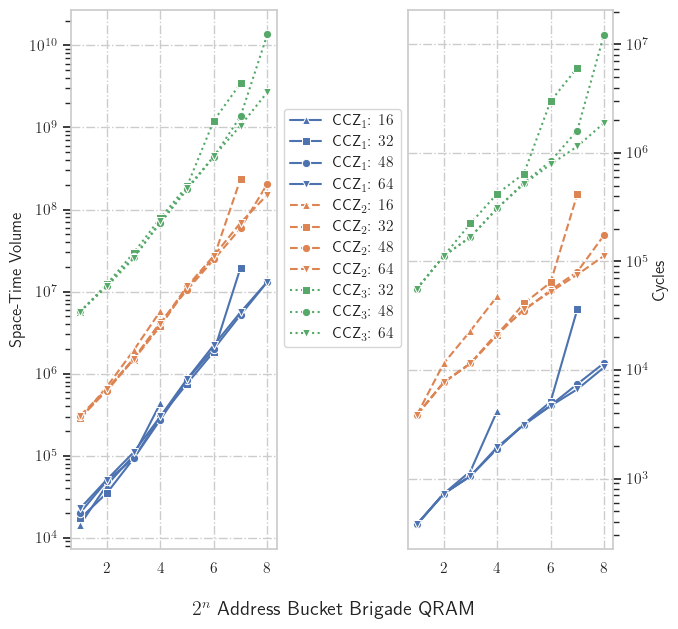

In [22]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

#f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#plt.grid(True,which="both")  


marks = ['^', 's', 'o', 'v']
linestyles = ['-', '--', ':']

target_key = 'distillery'
dependent = 'volume'
independent = 'address'
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax = [
    plt.subplot2grid((1, 5), (0, 0), colspan=2),
    plt.subplot2grid((1, 5), (0, 3), colspan=2)
]

subplot = ax[0]
kwargs = {
'errorbar':('ci', 100)
}

for idx, target in enumerate((1, 2, 3)):
    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_bb_small,
                independent,
                dependent,
                height=size,
                width=1,
                distillery=target
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )
subplot.legend_.remove()
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'

subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):

    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_bb_small,
                independent,
                dependent,
                height=size,
                width=1,
                distillery=target
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )
    
subplot.legend_.remove()
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')
subplot.set_ylabel('Cycles')

fig = plt.gcf()
fig.set_size_inches(7, 7)

lines = linestyles * 3
labels = sum(([f'DAG$_{target}$', f'Extern$_{target}$', f'CCZ$_{target}$'] for target in range(3)), start=list())

handles, labels = subplot.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.419, 0.75))
fig.supxlabel('$2^n$ Address Bucket Brigade QRAM')



#plt.savefig('bucket_brigade.pdf')